In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# load the SQL magic extension
# https://github.com/catherinedevlin/ipython-sql
# this extension allows us to connect to DBs and issue SQL command
%load_ext sql

In [4]:
# now we can use the magic extension to connect to our SQLite DB
# use %sql to write an inline SQL command
# use %%sql to write SQL commands in a cell
%sql sqlite:////content/drive/MyDrive/Northwind/northwind.sqlite3

In [5]:
# After connecting to the Northwind DB,
# let's first check what database engine we are using.
%%sql
SELECT sqlite_version();

 * sqlite:////content/drive/MyDrive/Northwind/northwind.sqlite3
Done.


sqlite_version()
3.37.2


## A quick look at Northwind DB

### How many tables does this DB have?

A database may contain many tables. Let's see how many tables we have in the Northwind DB.

Every SQLite database has a special table called `sqlite_master`. It contains a master listing of all database objects (tables, indexes, etc.) in the database and the SQL used to create each object. We can query this table to find out how many tables (excluding `sqlite_master`) we have in our Northwind DB.

We will use SQL keywords `SELECT...FROM...WHERE`. Don't worry about them for now. We will soon learn those keywords.

In [6]:
%%sql
SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';

 * sqlite:////content/drive/MyDrive/Northwind/northwind.sqlite3
Done.


name
Suppliers
Shippers
Employees
Customers
Orders
Categories
Products
OrderDetails


In [ ]:
%%sql
SELECT * FROM Products

In [ ]:
%%sql
SELECT
  strftime('%Y-%m', OrderDate) AS OrderMonth,
  SUM(Detail.Amount) AS MonthlySales
FROM Orders
JOIN (
  SELECT
    OrderID,
    (UnitPrice * Quantity * (1 - Discount)) AS Amount
  FROM OrderDetails
) AS Detail ON Orders.OrderID = Detail.OrderID
GROUP BY OrderMonth
ORDER BY OrderMonth;

In [ ]:
%%sql
SELECT
  strftime('%Y-%m', OrderDate) AS OrderMonth,
  ShipCountry,
  SUM(Detail.Amount) AS MonthlySales
FROM Orders
JOIN (
  SELECT
    OrderID,
    (UnitPrice * Quantity * (1 - Discount)) AS Amount
  FROM OrderDetails
) AS Detail ON Orders.OrderID = Detail.OrderID
GROUP BY OrderMonth, ShipCountry
ORDER BY OrderMonth, ShipCountry;

Our way-- Bring Data from database to python.

In [13]:
import pandas as pd
import sqlite3

# Adjust the path according to where your file is located
database_path = '/content/drive/MyDrive/Northwind/northwind.sqlite3'

# Connect to the database
conn = sqlite3.connect(database_path)

# Once connected, you can proceed to load your data into pandas DataFrames
# Example: orders = pd.read_sql_query("SELECT * FROM Orders", conn)



In [14]:
orders = pd.read_sql_query("SELECT * FROM Orders", conn)
order_details = pd.read_sql_query("SELECT * FROM OrderDetails", conn)

In [17]:
# Ensure the columns exist and are correctly named
print(orders.columns)
print(order_details.columns)

Index(['OrderID', 'CustomerID', 'EmployeeID', 'OrderDate', 'RequiredDate',
       'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress',
       'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry'],
      dtype='object')
Index(['OrderID', 'ProductID', 'UnitPrice', 'Quantity', 'Discount'], dtype='object')


In [18]:
import pandas as pd

# Assuming `orders` and `order_details` are your DataFrames
# First, calculate the Amount for each order detail
order_details['Amount'] = order_details['UnitPrice'] * order_details['Quantity'] * (1 - order_details['Discount'])

# Merge the Orders DataFrame with the OrderDetails DataFrame on OrderID
merged_df = pd.merge(orders, order_details[['OrderID', 'Amount']], on='OrderID')

# Convert OrderDate to datetime format to ensure correct handling
merged_df['OrderDate'] = pd.to_datetime(merged_df['OrderDate'])

# Create a new column for OrderMonth by formatting the OrderDate
merged_df['OrderMonth'] = merged_df['OrderDate'].dt.strftime('%Y-%m')

# Group by OrderMonth and sum up the Amounts for MonthlySales
monthly_sales = merged_df.groupby('OrderMonth')['Amount'].sum().reset_index()

# Sort the results by OrderMonth (this step might be optional as groupby should maintain order)
monthly_sales = monthly_sales.sort_values('OrderMonth')

# Display the DataFrame
print(monthly_sales)


   OrderMonth       Amount
0     2014-07   28169.0950
1     2014-08   25485.2750
2     2014-09   26381.4000
3     2014-10   37515.7250
4     2014-11   45600.0450
5     2014-12   45239.6300
6     2015-01   61258.0700
7     2015-02   38483.6350
8     2015-03   38547.2200
9     2015-04   53032.9525
10    2015-05   53781.2900
11    2015-06   36362.8025
12    2015-07   51020.8575
13    2015-08   47287.6700
14    2015-09   55629.2425
15    2015-10   66749.2260
16    2015-11   43533.8090
17    2015-12   71398.4285
18    2016-01   94222.1105
19    2016-02   99415.2875
20    2016-03  104854.1550
21    2016-04  124052.3025
22    2016-05   18333.6305


In [ ]:
import pandas as pd

# Assuming `orders` and `order_details` are your DataFrames and they're already loaded

# Calculate the Amount for each item in the OrderDetails DataFrame
order_details['Amount'] = order_details['UnitPrice'] * order_details['Quantity'] * (1 - order_details['Discount'])

# Merge the Orders DataFrame with the OrderDetails DataFrame on OrderID to include country and order date information
merged_data = pd.merge(orders, order_details[['OrderID', 'Amount']], on='OrderID')

# Convert OrderDate to datetime to ensure proper grouping by month
merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'])

# Extract year and month from OrderDate for grouping
merged_data['YearMonth'] = merged_data['OrderDate'].dt.to_period('M')

# Group by Country and YearMonth, then sum the Amounts to get MonthlySales
monthly_sales_by_country = merged_data.groupby(['ShipCountry', 'YearMonth'])['Amount'].sum().reset_index()

# Sort the results by Country and YearMonth for better readability
monthly_sales_by_country.sort_values(by=['ShipCountry', 'YearMonth'], inplace=True)

# Display the result
print(monthly_sales_by_country)


    ShipCountry YearMonth    Amount
0     Argentina   2015-01   319.200
1     Argentina   2015-02   443.400
2     Argentina   2015-04   225.500
3     Argentina   2015-05   110.000
4     Argentina   2015-10   706.000
..          ...       ...       ...
317   Venezuela   2016-01  5827.575
318   Venezuela   2016-02  1498.050
319   Venezuela   2016-03  5722.385
320   Venezuela   2016-04  6945.680
321   Venezuela   2016-05   673.920

[322 rows x 3 columns]


In [ ]:
import pandas as pd
employees = pd.read_sql_query("SELECT * FROM Employees", conn)
# Assuming `orders`, `order_details`, and `employees` are pre-loaded DataFrames.

# Calculate the Amount for each item in the OrderDetails DataFrame.
order_details['Amount'] = order_details['UnitPrice'] * order_details['Quantity'] * (1 - order_details['Discount'])

# Merge the Orders DataFrame with OrderDetails on OrderID to include Amount.
orders_with_details = pd.merge(orders, order_details[['OrderID', 'Amount']], on='OrderID')

# Merge the result with Employees to include EmployeeName.
sales_by_employee = pd.merge(orders_with_details, employees[['EmployeeID', 'LastName', 'FirstName']], on='EmployeeID')

# Convert OrderDate to datetime format for proper grouping by month.
sales_by_employee['OrderDate'] = pd.to_datetime(sales_by_employee['OrderDate'])

# Extract year and month from OrderDate for grouping purposes.
sales_by_employee['YearMonth'] = sales_by_employee['OrderDate'].dt.to_period('M')

# Group by EmployeeName and YearMonth, then sum the Amounts to get MonthlySales.
monthly_sales_by_employee_name = sales_by_employee.groupby(['EmployeeID', 'YearMonth', 'LastName', 'FirstName'])['Amount'].sum().reset_index()

# Sort the results by EmployeeName and YearMonth for better readability.
monthly_sales_by_employee_name.sort_values(by=['EmployeeID', 'YearMonth'], inplace=True)

# Display the result.
print(monthly_sales_by_employee_name)


     EmployeeID YearMonth   LastName FirstName     Amount
0             1   2014-07    Davolio     Nancy   1614.880
1             1   2014-08    Davolio     Nancy   5555.900
2             1   2014-09    Davolio     Nancy   6651.000
3             1   2014-10    Davolio     Nancy   3933.180
4             1   2014-11    Davolio     Nancy   9562.645
..          ...       ...        ...       ...        ...
187           9   2015-12  Dodsworth      Anne   1910.000
188           9   2016-01  Dodsworth      Anne   5353.319
189           9   2016-02  Dodsworth      Anne  19203.340
190           9   2016-03  Dodsworth      Anne   7045.000
191           9   2016-04  Dodsworth      Anne   9501.500

[192 rows x 5 columns]


In [ ]:
monthly_sales_by_employee_name

,EmployeeID,YearMonth,LastName,FirstName,Amount
0,1,2014-07,Davolio,Nancy,1614.880
1,1,2014-08,Davolio,Nancy,5555.900
2,1,2014-09,Davolio,Nancy,6651.000
3,1,2014-10,Davolio,Nancy,3933.180
4,1,2014-11,Davolio,Nancy,9562.645
...,...,...,...,...,...
187,9,2015-12,Dodsworth,Anne,1910.000
188,9,2016-01,Dodsworth,Anne,5353.319
189,9,2016-02,Dodsworth,Anne,19203.340
190,9,2016-03,Dodsworth,Anne,7045.000


Some Visualization

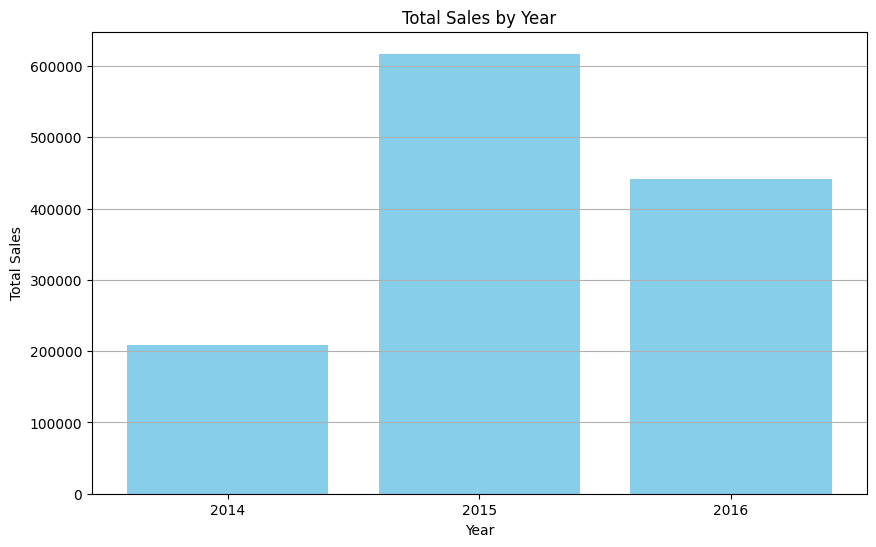

In [20]:
# Sales by Year
import pandas as pd
import matplotlib.pyplot as plt

# Assuming orders and order_details are your pre-loaded DataFrames

# Calculate the Amount for each order detail
order_details['Amount'] = order_details['UnitPrice'] * order_details['Quantity'] * (1 - order_details['Discount'])

# Merge orders with order_details on OrderID
merged_df = pd.merge(orders, order_details[['OrderID', 'Amount']], on='OrderID')

# Convert OrderDate to datetime to extract the year
merged_df['OrderDate'] = pd.to_datetime(merged_df['OrderDate'])
merged_df['Year'] = merged_df['OrderDate'].dt.year

# Group by Year and sum the Amounts to get total sales
yearly_sales = merged_df.groupby('Year')['Amount'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(yearly_sales['Year'], yearly_sales['Amount'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales by Year')
plt.xticks(yearly_sales['Year'])
plt.grid(axis='y')
plt.show()



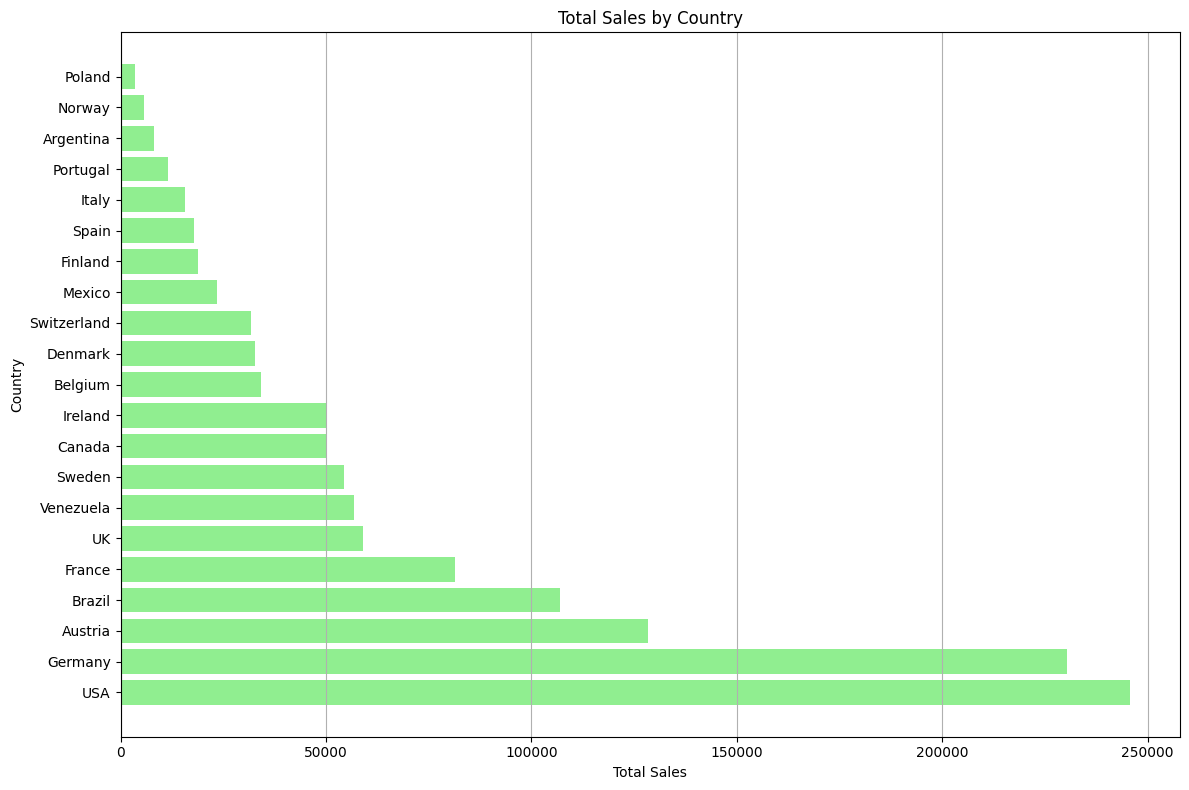

In [22]:
# Sales by Year
import pandas as pd
import matplotlib.pyplot as plt

# Assuming orders and order_details are your pre-loaded DataFrames

# Calculate the Amount for each order detail
order_details['Amount'] = order_details['UnitPrice'] * order_details['Quantity'] * (1 - order_details['Discount'])

# Merge orders with order_details on OrderID to include ShipCountry
merged_df = pd.merge(orders, order_details[['OrderID', 'Amount']], on='OrderID')

# Group by ShipCountry and sum the Amounts to get total sales
sales_by_country = merged_df.groupby('ShipCountry')['Amount'].sum().reset_index()

# Sorting sales by country for better visualization
sales_by_country.sort_values('Amount', ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(sales_by_country['ShipCountry'], sales_by_country['Amount'], color='lightgreen')
plt.xlabel('Total Sales')
plt.ylabel('Country')
plt.title('Total Sales by Country')
plt.grid(axis='x')
plt.tight_layout()  # Adjust layout to make room for the country labels
plt.show()


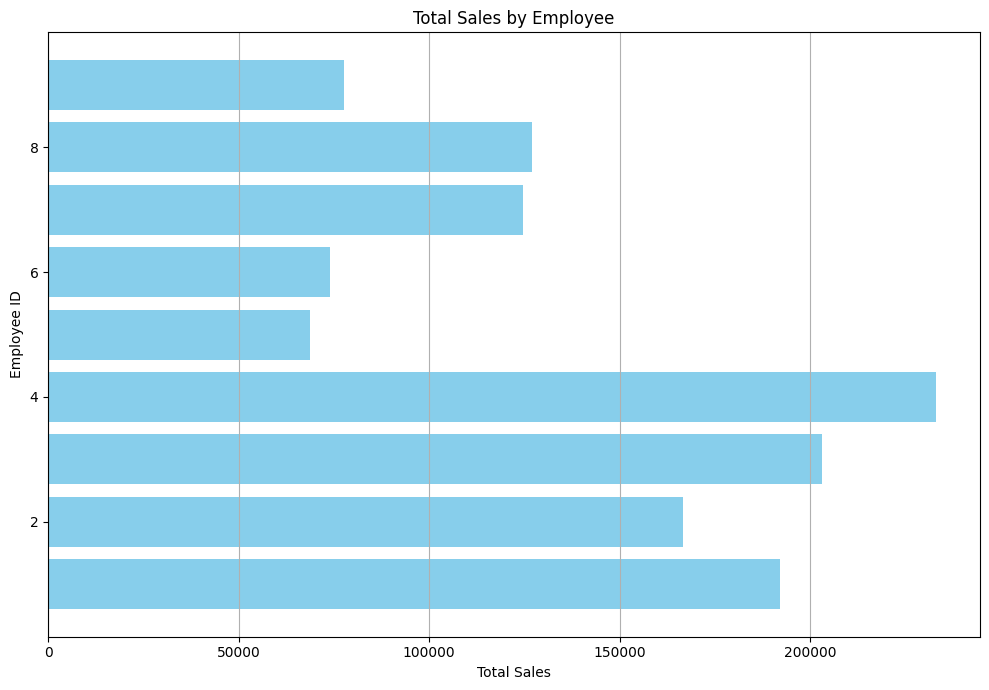

In [23]:
# Sales by Employee
import pandas as pd
import matplotlib.pyplot as plt

# Assuming orders and order_details are your pre-loaded DataFrames

# Calculate the Amount for each order detail
order_details['Amount'] = order_details['UnitPrice'] * order_details['Quantity'] * (1 - order_details['Discount'])

# Merge orders with order_details on OrderID to include EmployeeID
merged_df = pd.merge(orders, order_details[['OrderID', 'Amount']], on='OrderID')

# Group by EmployeeID and sum the Amounts to get total sales
sales_by_employee = merged_df.groupby('EmployeeID')['Amount'].sum().reset_index()

# If you have an employees DataFrame with EmployeeID and EmployeeName,
# you can merge it here to replace EmployeeID with EmployeeName for better readability:
# sales_by_employee = pd.merge(sales_by_employee, employees[['EmployeeID', 'LastName', 'FirstName']], on='EmployeeID')
# And then, for plotting, use 'EmployeeName' instead of 'EmployeeID'

# Sorting sales by employee for better visualization
sales_by_employee.sort_values('Amount', ascending=True, inplace=True)

# Plotting
plt.figure(figsize=(10, 7))
plt.barh(sales_by_employee['EmployeeID'], sales_by_employee['Amount'], color='skyblue')
plt.xlabel('Total Sales')
plt.ylabel('Employee ID')
plt.title('Total Sales by Employee')
plt.grid(axis='x')
plt.tight_layout()  # Adjust layout to make room for the labels
plt.show()


In [25]:
!pip install pandas matplotlib fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprex40jhl/3z8d045w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprex40jhl/tbdx0vte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16696', 'data', 'file=/tmp/tmprex40jhl/3z8d045w.json', 'init=/tmp/tmprex40jhl/tbdx0vte.json', 'output', 'file=/tmp/tmprex40jhl/prophet_modelsot6cjhf/prophet_model-20240403051628.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:16:28 - cmdstanpy - INFO - Chain [1] start processing
I

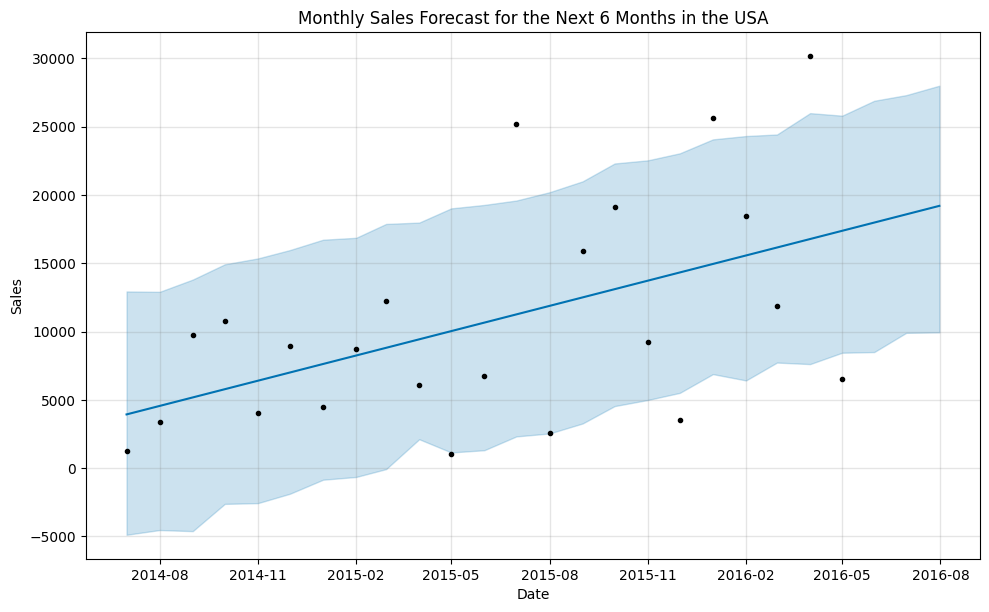

In [35]:
# Lets forecast
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Ensure OrderDate is in datetime format
orders['OrderDate'] = pd.to_datetime(orders['OrderDate'])

# Filter for sales in the USA
usa_orders = orders[orders['ShipCountry'] == 'USA']

# Calculate the Amount for each order detail
order_details['Amount'] = order_details['UnitPrice'] * order_details['Quantity'] * (1 - order_details['Discount'])

# Merge USA orders with order_details on OrderID
merged_usa_sales = pd.merge(usa_orders, order_details[['OrderID', 'Amount']], on='OrderID')

# Group by month to sum up sales for each month
merged_usa_sales['Month'] = merged_usa_sales['OrderDate'].dt.to_period('M')
monthly_sales_usa = merged_usa_sales.groupby('Month')['Amount'].sum().reset_index()
monthly_sales_usa.columns = ['ds', 'y']

# Convert 'ds' from Period to datetime for Prophet compatibility
monthly_sales_usa['ds'] = monthly_sales_usa['ds'].dt.to_timestamp()

# Initialize and fit the Prophet model
model = Prophet()
model.fit(monthly_sales_usa)

# Create a DataFrame to hold the future dates for prediction (next 6 months)
future = model.make_future_dataframe(periods=3, freq='M')

# Use the model to make a forecast
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title('Monthly Sales Forecast for the Next 6 Months in the USA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


RMSE: 12710.638268
